In [1]:
import matplotlib.pyplot as plt
import os
import itertools
import math
from random import randint
import pdb
import random

Każdy z buforów ma rozmiar 16 rekordów = 64 bajtów, więc każda operacja dyskowa polega na czytaniu lub zapisywaniu 64 bajtów z/na dysk.

In [2]:
# average record size in the file
# Ta stała określa rozmiar w bajtach pojedynczego rekordu, włączając dodatkowy znak (wg. wykładu ten na poczatku co okresla dl. rekordu).
# Pozostale to bok,bok i kat, czyli sumarycznie 4.
Single_record_size = 4


# Number_of_records - określa liczbę rekordów, które będą przechowywane w buforze w jednym momencie.
# Buforowanie poprawi wydajność operacji wejścia-wyjścia, minimalizując liczbę operacji odczytu i zapisu na dysk poprzez grupowanie ich w większe bloki.
# każdy bufor ma rozmiar 16 rekordów
Number_of_records = 16


# the size of a disk block that is a read/write unit
# Ta stała określa całkowity rozmiar bufora w bajtach.
# Jest to iloczyn liczby rekordów w buforze (Number_of_records) i rozmiaru jednego rekordu w bajtach (Single_record_size).
# Bufor o takim rozmiarze będzie używany do operacji odczytu i zapisu blokowego, co zwiększa efektywność przez minimalizację liczby operacji I/O

#  2^4 * 2^2 = 2^6= 64
Total_buffer_size = Number_of_records * Single_record_size


# wspolczynnik blokowania b
# b = B / R
# where:
# B – the size of a disk block that is a read/write unit; usually from a few
# to a dozen kB (such a block is also called a disk page);
# R – average record size in the file.

b = Total_buffer_size / Single_record_size

In [3]:
b

16.0

In [4]:
class Record:

  def __init__(self, elements):
    self.elements = elements
    #print(self.elements)
  def __repr__(self):
    return f"{self.elements}"



  #Przykład: x = [3, 10, 20, 30], to:
  #x[0] wynosi 3, co oznacza, że są 3 elementy.
  #x[1: 4] zwraca [10, 20, 30].
  #load_integers([3, 10, 20, 30]) zwróci obiekt Record z elementami [10, 20, 30].
  # tworze obiekt Record z listy liczb całkowitych,
  # gdzie pierwsza liczba określa liczbę elementów w Record, a pozostałe liczby są elementami

  # (z wykładu) Zazwyczaj rekordy mają nagłówki pokazujące strukturę rekordu

  # Funkcja ta służy do konwersji listy liczb całkowitych, z której pierwsza liczba
  # określa długość danych, na obiekt klasy Record. Jest szczególnie przydatna, gdy dane są zapisane
  # w postaci binarnej (lub w pliku), a po ich
  # odczycie należy przekształcić je w struktury bardziej zrozumiałe dla programu
  @staticmethod
  def load_integers(x):
    return Record(x[1: x[0] + 1])



  # przyklad: obiekt Record z elementami [10, 20] i Single_record_size wynosi 10:
  #len(self.elements) wynosi 2.
  #self.elements to [10, 20].
  #[0] * (10 - 2 - 1) daje [0] * 7, czyli siedem zer.
  #save_integers zwróci [2, 10, 20, 0, 0, 0, 0, 0, 0, 0].

  # konwertuje obiekt Record na listę liczb całkowitych, gdzie pierwszy element to liczba elementów,
  # a reszta to elementy, z dodatkowymi zerami na końcu do osiągnięcia określonego rozmiaru
  # to od +[0] moze być zakomentowane
  def save_integers(self):
    #pdb.set_trace()
    # to co zakomentowałem mogę dodac ale bez tego dziala, bo mam rekord stalej dlugosci, ale jest to pewnego rodzaju zabezpieczenie
    return [len(self.elements)] + self.elements #+ [0] * (Single_record_size - len(self.elements) - 1)

  # Metoda _lt_ porównuje dwa obiekty na podstawie ich unikalnych elementów
  def __lt__(self, other):
    if other is None:
        return True

    self_copy = list(self.elements)
    other_copy = list(other.elements)
    #pdb.set_trace()

    unique_self = self_copy[0] * self_copy[1] * math.sin(math.radians(self_copy[2]))
    unique_other = other_copy[0] * other_copy[1] * math.sin(math.radians(other_copy[2]))

    #sprawdzam czy unique_other jest pusty
    # jesli jest pusty oznacza to, że wszystkie elementy w other są obecne w self
    if not unique_other:
      # takim przypadku self nie jest mniejszy od other, więc metoda zwraca False
      return False

    # #sprawdzam czy unique_self jest pusty
    # jeśli unique_self jest pusty, oznacza to, że wszystkie elementy w self są obecne w other
    if not unique_self:
      # W takim przypadku self jest uznawany za mniejszy od other, więc metoda zwraca True
      return True
    #  Jeśli największy unikalny element w unique_other jest większy niż największy
    # unikalny element w unique_self, metoda zwraca True, co oznacza, że self jest mniejszy od other
    return unique_other > unique_self

In [5]:
class BufferToRead:

  def __init__(self, path):

    self.path = path
    self.read_possition = 0
    self.file_possition = 0
    self.size = Number_of_records
    self.file_size = os.path.getsize(path)
    # liczba rekordów obecnie załadowanych do bufora
    self.loaded_size = 0
    self.buffer = []
    self.disk_reads_count = 0
    #ładowanie początkowego zestawu danych do bufora
    self.load_next()

  def check_more(self):
    return (self.file_possition < self.file_size or self.read_possition < self.loaded_size)

  # see_next uzywam w SeriesIterator, gdzie weryfikuje gdzie konczy sie seria
  # (porownuje kolejne liczba z ta z poprzednia i ustawiam flage end_of_series)
  # dzieki see_next() mogą podglądnąc kolejny record bez przesuwania wskaznika

  def see_next(self):
    return None if self.read_possition == self.loaded_size else self.buffer[self.read_possition]

  # ODCZYT REKORDÓW: Metoda read_next zwraca następny rekord
  def read_next(self):
    # sprawdzam, czy są jeszcze rekordy do odczytu
    if not self.check_more():
        return None

    # jeśli są jakieś rekordy do odczytu to zwracam następny rekord z bufora
    record = self.buffer[self.read_possition]
    self.read_possition += 1

    # jeśli pozycja odczytu osiągnie rozmiar bufora
    if self.read_possition == self.size:
        # ładuje kolejną porcję danych do bufora (self.load_next())
        self.load_next()
        # resetuje self.read_possition
        self.read_possition = 0

    return record

  # Funkcja load_next jest używana do wczytywania rekordów z pliku binarnego.
  # Umożliwia ona kontrolowanie pozycji wskaźnika pliku, zarządzanie buforowaniem
  # danych oraz konwertowanie surowych bajtów na struktury danych, które mogą być używane w programie

  def load_next(self):
    self.buffer = []
    with open(self.path, "rb", buffering =0) as f:
      # seek() function is used to change the position of
      # the File Handle to a given specific position
      # przesuwam wskaźnik odczytu pliku do self.file_pos
      # oznacza to, że odczyt zacznie się od tej pozycji w pliku.

      f.seek(self.file_possition)

      # obliczam, ile bajtów można odczytać, biorąc minimum z zdefiniowanego rozmiaru bufora (Total_buffer_size)
      # oraz dostępnej przestrzeni do końca pliku (self.file_size - self.file_possition).
      bytes_to_read = min(Total_buffer_size, self.file_size - self.file_possition)

      # odczytuję określoną liczbę bajtów z pliku
      temporrary_buffer = f.read(bytes_to_read)

      # przesuwam wskaźnik pliku o liczbę odczytanych bajtów, przygotowując się do następnego odczytu w przyszłości
      self.file_possition += bytes_to_read

      # obliczam liczbę załadowanych rekordów na podstawie odczytanej liczby bajtów.
      self.loaded_size = bytes_to_read / Single_record_size

      # konwertuje temporrary_buffer na listę liczb całkowitych
      temporrary_list_buffer = list(temporrary_buffer)


      #pdb.set_trace()

      # wyciągam fragmenty listy z bufora tymczasowego, które odpowiadają pełnym rekordom danych
      # tutaj zwracam uwagę, że i nie wzrasta o 1, tylko o ten krok tutaj, czyli o Single_record_size !!
      for i in range(0, len(temporrary_buffer), Single_record_size):
        # Fragment listy odpowiadający pełnemu rekordowi danych
        full_record = temporrary_list_buffer[i:i + Single_record_size]

        # tworze obiekt Record na podstawie wyciągniętej listy liczb całkowitych
        # czyli dodam wartosci juz bez inforamcji o dlugosci rekordu
        self.buffer.append(Record.load_integers(full_record))
        #pdb.set_trace()
      # zamykam plik i zwiększam licznik operacji odczytu z dysku (self.disk_reads_count)
      f.close()

      #print("Zwiększam odczyty!!")
      self.disk_reads_count += 1


  def __iter__(self):
    return self

  def __next__(self):
    next_record = self.read_next()
    if next_record is None:
      raise StopIteration
    return next_record


In [6]:
class BufferToWrite:

  def __init__(self, path, append_mode=False):

    self.write_possition = 0
    self.buffer = [None] * Number_of_records

    self.path = path
    self.size = Number_of_records

    self.series_written = 0
    self.last_written = None
    self.disk_writes_count = 0

    #  jeśli istnieje plik o tej samej nazwie, zostaje on najpierw usunięty, aby można było stworzyć nowy plik od zera
    if not append_mode and os.path.isfile(path):
      os.remove(path)


  def save_next(self):
    integers_to_write = []
    #pdb.set_trace()
    # dla każdego rekordu wywołuje metodę save_integers, która konwertuje rekord na listę liczb całkowitych
    for record in self.buffer[0:self.write_possition]:
      integers_to_write += record.save_integers()
    # otwieram plik w trybie append binary ("ab"), co oznacza, że dane będą dodawane na końcu pliku w trybie binarnym
    # ustawienie buffering=0 oznacza, że operacje zapisu będą natychmiastowe, bez buforowania
    with open(self.path,"ab", buffering = 0) as f:
      f.write(bytearray(integers_to_write))
      f.close()
      #print("Zwiększam zapisy!!!")
      self.disk_writes_count += 1


  def flush(self):
    # setattr ustawia atrybut write_possition obiektu self na 0
    # do tego przypisania dojdzie tylko wtedy, gdy self.save_next() zwróci False
    self.write_possition > 0 and (self.save_next() or setattr(self, 'write_possition', 0))

  def write_next(self, record):

    # jeśli bieżący rekord jest mniejszy od ostatnio zapisanegom, to oznacza to początek nowej serii.
    # dlatego licznik zapisanych serii (self.series_written) jest zwiększany o 1
    if record < self.last_written:
      self.series_written += 1
    # jeśli pozycja zapisu osiągnie rozmiar bufora, oznacza to, że bufor jest pełny i trzeba go opróżnić
    if self.write_possition == self.size:
      self.flush()
    # zapis bieżącego rekordu na bieżącej pozycji w buforze
    self.buffer[self.write_possition] = record
    # zwiększam aktualną pozycję zapisu o 1, przygotowując sie do zapisu następnego rekordu
    self.write_possition += 1
    # ustawiam ostatnio zapisany rekord na bieżący rekord, aby można było go porównać z następnym rekordem
    self.last_written = record

In [7]:
# Dzięki klasie SeriesIterator weryfikuje gdzie konczy się seria, wiec mogę otrzymać rekordy podzielone na serie
class SeriesIterator:

  def __init__(self, read_buffer):
    self.read_buffer = read_buffer
    self.end_of_series = False
    self.current_record = None

  def read_next(self):
    #pdb.set_trace()

    # jesli zosała ustawiona flaga konca serii to zwracam None
    if self.end_of_series:
      return None

    # odczytuje kolejne rekordy i przypisuje je do current_record
    # tu nalezy zaznaczyc ze read_next() sam przesunie wskaznik na
    # kolejny rekord
    self.current_record = self.read_buffer.read_next()

    if self.current_record is None:
      return None

    # podgladam jaki bedzie nastepny rekord
    next_record = self.read_buffer.see_next()

    # tu jesli pogdlądniety rekord jest mniejszy od poprzedniego to oznacza ze zakonczyła sie pewna seria
    if next_record is not None and next_record < self.current_record:
      # i wtedy nalezy ustawic flage konca serii na true
      self.end_of_series = True

    # zwracam obecny rekord
    return self.current_record

  def __iter__(self):
    return self

  def __next__(self):
    # jesli została ustawiona flaga end_of_series na True to self.read_next() będzie równy None
    # i wtedy jest StopIteration bo koniec serii
    res_record = self.read_next()
    if res_record is None:
      raise StopIteration
    return res_record

In [21]:
def show_tape(name):

  buffer = BufferToRead(name)
  series_counter = 0
  records_counter = 0
  while buffer.check_more():
    #pdb.set_trace()
    iterator = SeriesIterator(buffer)
    series = []
    for r in iterator:
      series.append(r)
      records_counter +=1
    # gdy wyjdzie z petli to dodaje '||' na koniec serii
    print(" ".join(map(str, series)), end=" | " if buffer.check_more() else "\n")

    # i zwiekszam licznik serii
    series_counter +=1

  print(f'\nSeries count: {series_counter}')
  print(f'Records count: {records_counter}')

Funkcja split ta rozdziela rekordy z pliku źródłowego (tape) na dwie taśmy (first_tape i second_tape), tworząc na nich posortowane sekwencje.

Robi to, sprawdzając kolejność rekordów i zmieniając taśmę docelową, gdy znajdzie rekord mniejszy od poprzedniego (co oznacza początek nowej sekwencji)

tape = [4, 1, 3, 7, 2, 6, 5]

Rekord 4 zapisuje do first_tape

Kolejny rekord to 1.Jest on mniejszy od 4, więc zmieniamy taśmę docelową na second_tape i zapisujemy 1.

Rekord 3 jest większy od 1, więc nadal zapisujemy do second_tape

Rekord 7 jest większy od 3, więc nadal zapisujemy do second_tape

Rekord 2 jest mniejszy od 7, więc zmieniamy taśmę docelową z powrotem na first_tape i zapisujemy 2

itd..

Otrzymujemy:

first_tape: [4, 2, 6]

second_tape: [1, 3, 7, 5]

In [22]:
#Funckja split rozdziela rekordy z pliku źródłowego na dwa docelowe pliki (tasmy), tworząc w nich sekwencje posortowane

# DYSTRYBUCJA
def split(first_tape, second_tape,tape):

  read_buffer = BufferToRead(tape)
  write_buffer_first = BufferToWrite(first_tape)
  write_buffer_second = BufferToWrite(second_tape)

  # następny rekord z pliku źródłowego za pośrednictwem bufora odczytu (BufferToRead)
  next_record = read_buffer.read_next()
  # do bufora write_buffer_first (pierwsza tasma) zapisuje 1 element z read_buffer
  write_buffer_first.write_next(next_record)

  # moja destynacją obecnie jest write_buffer_first (tasma pierwsza)
  destination_buffer = write_buffer_first
  # zaczynam zapisywac do write_buffer_first i jesli kolejny record jest wiekszy od poprzednika to zapisuje w write_buffer_second
  # calosc opiera sie na odpowiedniej zmianie destination_buffer
  for r in read_buffer:
    #pdb.set_trace()
    if r < next_record:
      destination_buffer = write_buffer_second if destination_buffer == write_buffer_first else write_buffer_first

    (write_buffer_first if destination_buffer == write_buffer_first else write_buffer_second).write_next(r)
    next_record = r

  # Flushing buforów na końcu zapisuje wszystkie pozostałe dane z buforów do plików, zapewniając,
  # że wszystkie dane są zapisywane i bufor jest pusty przed kolejnymi operacjami
  write_buffer_first.flush()
  write_buffer_second.flush()

  print("\nTape 1: ")
  #print(write_buffer_first)
  show_tape(first_tape)
  print("\nTape 2 :")
  show_tape(second_tape)

  return Metadane(read_buffer.disk_reads_count,
  # write_buffer_first.disk_writes_count + write_buffer_second.disk_writes_count: Łączna liczba operacji zapisu na dysku dla obu buforów
  write_buffer_first.disk_writes_count + write_buffer_second.disk_writes_count,
  # write_buffer_first.series_written + write_buffer_second.series_written: Łączna liczba sekwencji posortowanych (runs) zapisanych do obu buforów
  write_buffer_first.series_written + write_buffer_second.series_written)

Funkcja series_merge łączy dwie posortowane sekwencje z first_tape i second_tape w jedną posortowaną sekwencję na trzeciej taśmie (write_buffer)

first_tape = [4, 2, 6]

second_tape = [1, 3, 7, 5]

1 (z second_tape) jest mniejsze niż 4 (z first_tape), więc zapisuje 1

Następnie porównuje 3 (następny w second_tape) z 4, dlatego zapisuje 3

 W rezultacie write_buffer będzie zawierać posortowaną sekwencję rekordów

In [10]:

# Funkcja series_merge jest używana do scalenia dwóch posortowanych sekwencji rekordów w jedną posortowaną sekwencję na trzeciej tasmie write_buffer
def series_merge(first_tape, second_tape, write_buffer: BufferToWrite):

  # records_in_tape1 - kolejne wartosc z t1
  records_in_tape1 = first_tape.read_next()
  # records_in_tape2 - kolejne wartosc z t2
  records_in_tape2 = second_tape.read_next()
  #pdb.set_trace()
  while records_in_tape1 is not None and records_in_tape2 is not None:

    # sprawdzam czy rekord z tasmy 1 jest mniejszy niz z tasmy 2
    if records_in_tape1 < records_in_tape2:
      # jesli rekord z tasmy 1 jest mniejszy to zapisuje go (ten z pierwszej tasmy) do buffora
      write_buffer.write_next(records_in_tape1)
      # i odczytuje kolejny rekord
      records_in_tape1 =  first_tape.read_next()
    else:
      # jesli rekord z tasmy 1 jest wiekszy niz z tasmy 2 to zapisuje rekord (z drugiej tasmy) do bufora
      write_buffer.write_next(records_in_tape2)
      # odczytuje kolejny rekord z drugiej tasmy
      records_in_tape2 = second_tape.read_next()

  # gdy wyjde poza tasme
  for tape in (first_tape, second_tape):
    #pdb.set_trace()
    # teraz sprawdzam czy to z tasmy 1 czy z tasmy 2 wyszedłem poza nią (czyli uzyskałem None)
    possibly_none_value = records_in_tape1 if tape == first_tape else records_in_tape2
    #pdb.set_trace()
    if possibly_none_value is not None:
      # brakujacy rekord z taśmy z której nie wyszedłem zapisuje do write_buffer
      write_buffer.write_next(possibly_none_value)
      # na taśmie z której nie uzyskałem None pozostały mi jeszcze wartości

      # musze jeszcze sprawdzic pozostałe rekordy z tej
      # z ktorej jeszcze nie wypisałem wszystkich rekordow
      for remaining_records in tape:
        #pdb.set_trace()
        #print(f"Brakujące: {remaining_records}")
        #zapisuje pozstałe rekordy
        write_buffer.write_next(remaining_records)

Funkcja merge służy do scalania zawartości dwóch posortowanych taśm (first_tape i second_tape) w jedną docelową (tape)

W pętli while sprawdza, czy na obu taśmach (first_tape i second_tape) znajdują się jeszcze rekordy do scalenia. Następnie wywołuje series_merge dla każdej pary posortowanych serii z obu taśm

Gdy wszystkie serie zostaną przetworzone, merge zapisuje wszystko, co pozostało na obu taśmach, do taśmy wyjściowej, aby ostateczny wynik zawierał wszystkie rekordy


ROŻNICE POMIĘDZY 'merge' i 'series_merge':

Funkcja merge jest odpowiedzialna za połączenie całych posortowanych taśm w jeden posortowany wynik, podczas gdy series_merge scala tylko pojedyncze serie w obrębie jednej operacji merge

In [11]:
# Funkcja merge łączy dwie POSORTOWANE TASMY (tasme1 i tasme2) w jedną większą posortowaną sekwencję (wywołując series_merge)
def merge(first_tape, second_tape, tape):
  write_buffer = BufferToWrite(tape)
  #pdb.set_trace()
  read_buffer_first = BufferToRead(first_tape)# tasma 1
  read_buffer_second = BufferToRead(second_tape)# tasma 2
  #pdb.set_trace()
  # jesli na tasme 1 i tasme 2 sa jeszcze jakies wartosci
  while read_buffer_first.check_more() and read_buffer_second.check_more():
    # scalam posortowane serie z obu taśm do bufora zapisu (write_buffer)
    series_merge(SeriesIterator(read_buffer_first), SeriesIterator(read_buffer_second), write_buffer)

  # z bufora tasmy 1 i bufora tasmy 2 zapisuje wszystko do bufora zapisu na tasme
  for buffer in (read_buffer_first, read_buffer_second):
    for r in buffer:
        write_buffer.write_next(r)

  write_buffer.flush()

  return Metadane(read_buffer_first.disk_reads_count + read_buffer_second.disk_reads_count,
                  write_buffer.disk_writes_count,
                  write_buffer.series_written)

In [12]:
def sort_and_info(tape):

  phases_count = 0
  series_written = 0

  writes_count = 0
  reads_count = 0

  # jeśli liczba serii wynosi 1, wszystkie dane na taśmie są już posortowane
  while series_written != 1:

    split_information = split("tapes/t2", "tapes/t3", tape)
    merge_information = merge("tapes/t2", "tapes/t3", tape)

    series_written = merge_information.series_count

    writes_count += split_information.writes_count
    writes_count += merge_information.writes_count

    reads_count += split_information.reads_count
    reads_count += merge_information.reads_count
    print(f'\nPhase: {phases_count + 1}')
    print("Tape 3:")
    show_tape(tape)
    #print(f'Reads count: {reads_count}')
    #print(f'Writes count: {writes_count}')
    phases_count +=1

  # zwracam obiekt MetaSorting zawierający liczbę odczytów, zapisów i faz sortowania, co pozwala na analizę wydajności algorytmu.
  return MetaSorting(reads_count, writes_count, phases_count)


In [13]:
from collections import namedtuple

Metadane = namedtuple('Metadane', ['reads_count', 'writes_count', 'series_count'])
MetaSorting = namedtuple('MetaSorting', ['reads_count', 'writes_count', 'phases_count'])

Wywoływanie

In [14]:
folder_name = 'tapes'
os.makedirs(folder_name, exist_ok=True)
!rm tapes/t1
!rm tapes/t2
!rm tapes/t3
tape = "tapes/t1"
test_file_path = "tapes/test"

rm: cannot remove 'tapes/t1': No such file or directory
rm: cannot remove 'tapes/t2': No such file or directory
rm: cannot remove 'tapes/t3': No such file or directory


Funkcje potrzebne do wykresu zmiany wartości pola wraz z kolejnymi indeksami rekordu

In [15]:
# obliczanie wartości pola
def calculate_field_value(record):

    bok1, bok2, kat = record.elements
    return bok1 * bok2 * math.sin(math.radians(kat))

# zbieram wartości pól, co posłuzy mi do rysowania wykresu
def plot_field_values(tape):
    read_buffer = BufferToRead(tape)
    field_values = []

    for record in read_buffer:
        field_value = calculate_field_value(record)
        field_values.append(field_value)

    # tworze wykresy wartości pól
    plt.figure(figsize=(8, 5))
    plt.plot(field_values, marker='o', linestyle='-', color='b')
    plt.title("Wartości pól rekordów")
    plt.xlabel("Indeks rekordu")
    plt.ylabel("Wartość pola")
    plt.grid(True)
    plt.show()

Generating Random

In [16]:
num_rows = int(input("Podaj liczbę wierszy do wygenerowania: "))

# lista na przechowywanie wszystkich wygenerowanych wierszy
all_rows = []

# generuje num_rows wierszy
for _ in range(num_rows):
  # trzy losowe liczby
  row = [random.randint(1, 10), random.randint(1, 10), random.randint(1, 100)]
  all_rows.append(row)  # dodanie wiersza do listy all_rows

write_buffer = BufferToWrite(tape, append_mode=True)
count = 0
for i in all_rows:
  new_record = Record(i)
  write_buffer.write_next(new_record)
  count += 1
write_buffer.flush()
print(f'Added {count} records to tape')

Podaj liczbę wierszy do wygenerowania: 12
Added 12 records to tape


Showing what was generated

In [17]:
all_rows

[[7, 4, 15],
 [8, 3, 34],
 [4, 3, 7],
 [4, 6, 41],
 [9, 3, 86],
 [7, 6, 95],
 [8, 8, 37],
 [1, 3, 23],
 [4, 1, 54],
 [6, 7, 84],
 [4, 3, 28],
 [1, 10, 24]]

Calculating field from random generating

In [18]:
results = []
for row in all_rows:
    bok1 = row[0]
    bok2 = row[1]
    kat = math.sin(math.radians(row[2]))
    result = bok1 * bok2 * kat
    results.append(result)

# wyświetlanie wyników
for i, result in enumerate(results):
    print(f"Result for row: {i + 1}: {result:.4f}")

Result for row: 1: 7.2469
Result for row: 2: 13.4206
Result for row: 3: 1.4624
Result for row: 4: 15.7454
Result for row: 5: 26.9342
Result for row: 6: 41.8402
Result for row: 7: 38.5162
Result for row: 8: 1.1722
Result for row: 9: 3.2361
Result for row: 10: 41.7699
Result for row: 11: 5.6337
Result for row: 12: 4.0674


Sorting from generating

In [19]:
# lista, do przechowywania wierszy i ich wynikow
results_with_rows = []

# obliczam wartości dla każdego wiersza
for row in all_rows:
    bok1 = row[0]
    bok2 = row[1]
    kat = math.sin(math.radians(row[2]))  # Przeliczenie kąta na radiany i obliczenie sinusa
    result = bok1 * bok2 * kat  # Obliczenie wzoru
    results_with_rows.append((result, row))  # Zapisanie wyniku wraz z oryginalnym wierszem

# Sortowanie wyników rosnąco względem wartości obliczeń
results_with_rows.sort(key=lambda x: x[0])

# Wyświetlanie wyników po posortowaniu
print("Posortowane wyniki:")
for result, row in results_with_rows:
    print(f"Wynik: {result:.4f}, Wiersz: {row}")

Posortowane wyniki:
Wynik: 1.1722, Wiersz: [1, 3, 23]
Wynik: 1.4624, Wiersz: [4, 3, 7]
Wynik: 3.2361, Wiersz: [4, 1, 54]
Wynik: 4.0674, Wiersz: [1, 10, 24]
Wynik: 5.6337, Wiersz: [4, 3, 28]
Wynik: 7.2469, Wiersz: [7, 4, 15]
Wynik: 13.4206, Wiersz: [8, 3, 34]
Wynik: 15.7454, Wiersz: [4, 6, 41]
Wynik: 26.9342, Wiersz: [9, 3, 86]
Wynik: 38.5162, Wiersz: [8, 8, 37]
Wynik: 41.7699, Wiersz: [6, 7, 84]
Wynik: 41.8402, Wiersz: [7, 6, 95]


From File

In [33]:
write_buffer = BufferToWrite(tape, append_mode=True)
count = 0

with open(test_file_path) as test_file:
  for line in test_file:
    set_numbers = [int(s) for s in line.rstrip().split()]
    new_record = Record(set_numbers)
    #pdb.set_trace()
    write_buffer.write_next(new_record)
    count += 1
write_buffer.flush()
print(f'Added {count} records to tape')

Added 7 records to tape


From Keyboard

In [30]:
num_rows = int(input("Podaj liczbę rekordow do wprowadzenia: "))

# Lista na wprowadzone rekordy
all_rows = []


for row_index in range(num_rows):
  print(f"Rekord {row_index + 1}:")
  row = []
  for col_index in range(3):
    value = int(input(f"  Wprowadź wartosci rownlolegloboka (bok, bok, kat) {col_index + 1}: "))
    row.append(value)
  all_rows.append(row)


write_buffer = BufferToWrite(tape, append_mode=True)
count = 0
for i in all_rows:
  new_record = Record(i)
  write_buffer.write_next(new_record)
  count += 1
write_buffer.flush()
print(f'Added {count} records to tape')

Podaj liczbę rekordow do wprowadzenia: 6
Rekord 1:
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 1: 2
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 2: 3
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 3: 30
Rekord 2:
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 1: 4
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 2: 2
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 3: 30
Rekord 3:
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 1: 1
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 2: 2
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 3: 30
Rekord 4:
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 1: 7
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 2: 2
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 3: 30
Rekord 5:
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 1: 5
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 2: 2
  Wprowadź wartosci rownlolegloboka (bok, bok, kat) 3: 30
Rekord 6:
  Wprowadź wartosci rownlolegloboka (bo

Sorting

In [20]:
print(f"Sorting tape {tape}")
print(f"Tape before sorting:")
show_tape(tape)
sort_info = sort_and_info(tape)
print(f"\nTape after sorting:")
show_tape(tape)
print(f"Metadata:")
print(f"Phase counter: {sort_info.phases_count}")
print(f"Reads counter: {sort_info.reads_count}")
print(f"Writes counter: {sort_info.writes_count}")

Sorting tape tapes/t1
Tape before sorting:
[7, 4, 15] [8, 3, 34] | [4, 3, 7] [4, 6, 41] [9, 3, 86] [7, 6, 95] | [8, 8, 37] | [1, 3, 23] [4, 1, 54] [6, 7, 84] | [4, 3, 28] | [1, 10, 24]

Series count: 6
Records count: 12

Tape 1: 
[7, 4, 15] [8, 3, 34] [8, 8, 37] | [4, 3, 28]

Series count: 2
Records count: 4

Tape 2 :
[4, 3, 7] [4, 6, 41] [9, 3, 86] [7, 6, 95] | [1, 3, 23] [4, 1, 54] [6, 7, 84] | [1, 10, 24]

Series count: 3
Records count: 8

Phase: 1
Tape 3:
[4, 3, 7] [7, 4, 15] [8, 3, 34] [4, 6, 41] [9, 3, 86] [8, 8, 37] [7, 6, 95] | [1, 3, 23] [4, 1, 54] [4, 3, 28] [6, 7, 84] | [1, 10, 24]

Series count: 3
Records count: 12

Tape 1: 
[4, 3, 7] [7, 4, 15] [8, 3, 34] [4, 6, 41] [9, 3, 86] [8, 8, 37] [7, 6, 95] | [1, 10, 24]

Series count: 2
Records count: 8

Tape 2 :
[1, 3, 23] [4, 1, 54] [4, 3, 28] [6, 7, 84]

Series count: 1
Records count: 4

Phase: 2
Tape 3:
[1, 3, 23] [4, 3, 7] [4, 1, 54] [4, 3, 28] [7, 4, 15] [8, 3, 34] [4, 6, 41] [9, 3, 86] [8, 8, 37] [6, 7, 84] [7, 6, 95] | [1,

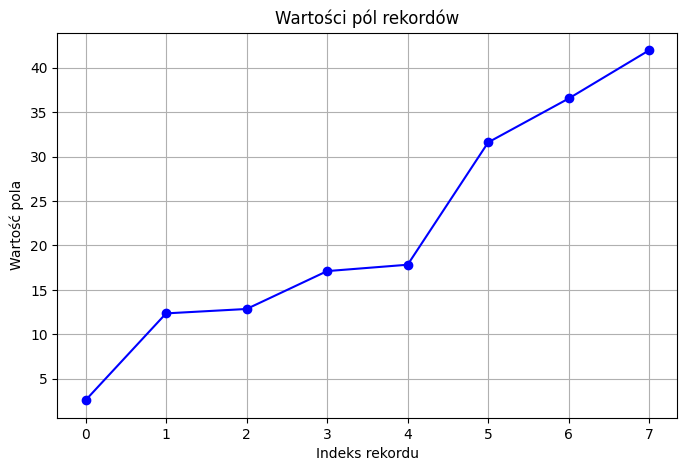

In [28]:
plot_field_values(tape)

TESTING AND PLOTING FOR A REPORT

In [61]:
import random

def generate_data(tape, num_rows):
    all_rows = []
    for _ in range(num_rows):
        row = [random.randint(1, 10), random.randint(1, 10), random.randint(1, 100)]
        all_rows.append(row)

    write_buffer = BufferToWrite(tape, append_mode=True)
    count = 0
    for i in all_rows:
        new_record = Record(i)
        write_buffer.write_next(new_record)
        count += 1
    write_buffer.flush()
    print(f'Added {count} records to tape')

In [62]:
def generate_and_sort_records(tape, num_rows_list):
    phases = []
    reads = []
    writes = []
    theoretical_phases_list = []
    theoretical_operations_list = []

    for num_rows in num_rows_list:
        # generowanie danych
        print(f"Generating {num_rows} records...")
        generate_data(tape, num_rows)

        # sortuje
        print(f"Sorting tape {tape}...")
        sort_info = sort_and_info(tape)

        # zbieranie danych praktycznych
        phases.append(sort_info.phases_count)
        reads.append(sort_info.reads_count)
        writes.append(sort_info.writes_count)

        # obliczam dane teoretycznych
        te_phase, te_operations = theoretical_phases(num_rows)
        theoretical_phases_list.append(te_phase)
        theoretical_operations_list.append(te_operations)

    # rysowanie wykresów
    plt.figure(figsize=(14, 7))

    # wykres faz
    plt.subplot(1, 2, 1)
    plt.plot(num_rows_list, phases, label='Fazy praktyczne', marker='o')
    plt.plot(num_rows_list, theoretical_phases_list, label='Fazy teoretyczne', marker='o')
    plt.title('Liczba faz sortowania')
    plt.xlabel('Liczba rekordów')
    plt.ylabel('Liczba faz')
    plt.xscale('log')
    plt.yscale('linear')
    plt.legend()
    plt.grid()

    # zapis wykresu operacji jako jpeg
    plt.savefig('operacje_dyskowe.png')

    # wykres operacji dyskowych
    plt.subplot(1, 2, 2)
    plt.plot(num_rows_list, reads, label='Odczyty praktyczne', marker='o')
    plt.plot(num_rows_list, writes, label='Zapisy praktyczne', marker='o')
    plt.plot(num_rows_list, theoretical_operations_list, label='Operacje teoretyczne', marker='o')
    plt.title('Liczba operacji dyskowych')
    plt.xlabel('Liczba rekordów')
    plt.ylabel('Liczba operacji')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid()

    # zapis wykresu faz jako plik jpg
    plt.savefig('fazy_sortowania.png')

    plt.tight_layout()
    plt.show()

In [63]:
def theoretical_phases(num_rows):
    # teoretyczna liczba faz
    phases = math.log(num_rows, 2)
    #phases = math.ceil(math.log(num_rows, 2))
    #phases = math.log2(num_rows)
    # teoretyczna liczba operacji (odczytów i zapisów)
    operations = ((4 * num_rows) * phases) / b

    return phases, operations

Generating 100 records...
Added 100 records to tape
Sorting tape tapes/t1...

Tape 1: 
[8, 2, 21] [9, 2, 24] [2, 9, 65] [6, 3, 98] [3, 10, 62] [5, 10, 74] [10, 9, 43] [10, 9, 72] | [10, 1, 22] [6, 7, 95] | [8, 8, 4] [3, 4, 99] [6, 4, 92] | [1, 4, 33] [1, 7, 26] [10, 4, 29] | [5, 5, 9] [9, 2, 21] [2, 8, 69] [5, 4, 78] [10, 9, 92] | [8, 1, 35] [1, 10, 36] [5, 8, 83] | [5, 6, 44] | [3, 10, 11] [1, 6, 77] [7, 2, 45] | [4, 5, 26] | [7, 4, 18] | [4, 3, 38] [4, 5, 45] | [2, 5, 43] | [1, 5, 27] [8, 7, 83] | [3, 8, 25] [7, 6, 60] | [3, 5, 10] [8, 4, 37] [10, 9, 62] | [9, 4, 6] [10, 3, 13] [5, 7, 49] | [2, 2, 76] [5, 7, 81] | [3, 7, 1] [5, 3, 8] [8, 10, 74] | [3, 5, 37] [4, 9, 57] | [6, 3, 68] | [8, 5, 6] [10, 6, 73] | [3, 2, 53]

Series count: 22
Records count: 54

Tape 2 :
[3, 1, 36] [9, 10, 83] | [5, 2, 54] | [2, 2, 75] [10, 5, 58] | [2, 2, 89] [7, 8, 73] | [3, 7, 9] | [2, 4, 23] [6, 8, 88] | [5, 4, 60] [8, 7, 91] [9, 9, 46] | [3, 1, 92] [10, 6, 91] | [4, 6, 23] [1, 10, 81] [7, 5, 20] [8, 6, 

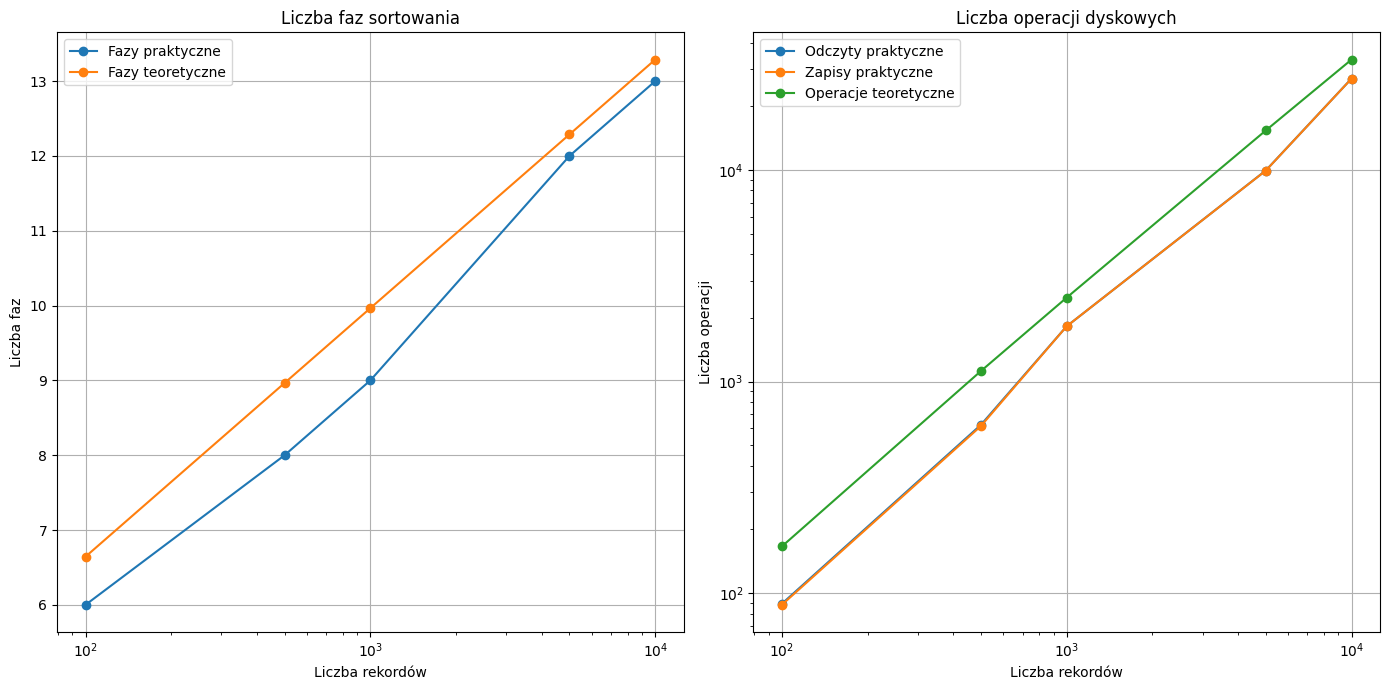

In [64]:
num_rows_list = [100, 500, 1000, 5000,10000]
generate_and_sort_records(tape, num_rows_list)

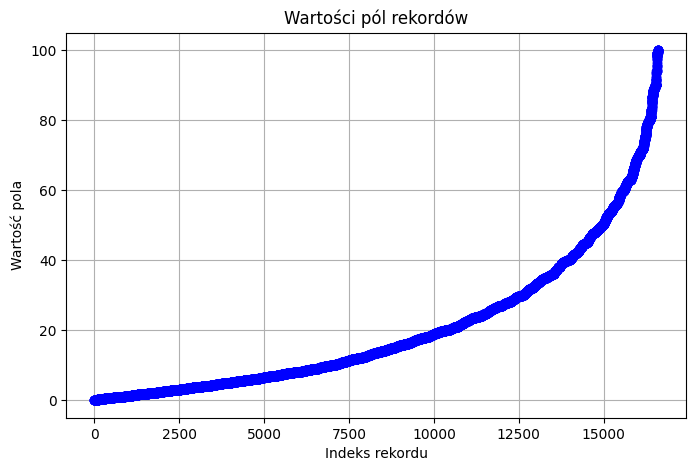

In [40]:
plot_field_values(tape)